**DOWNLOADING DATASETS**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,922 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,392 kB]
Hit:10 https://ppa.launchpadcon
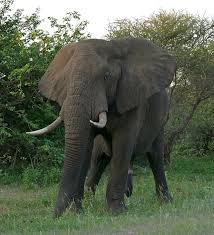
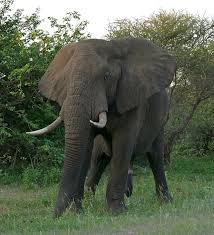
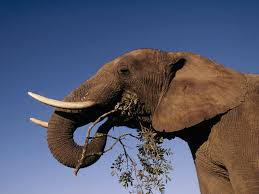
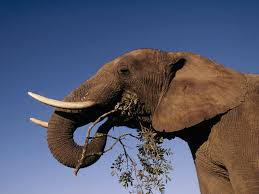
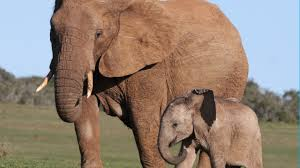
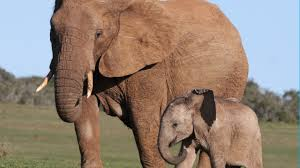
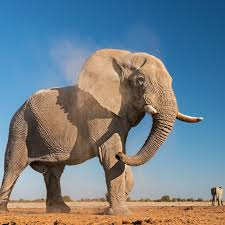
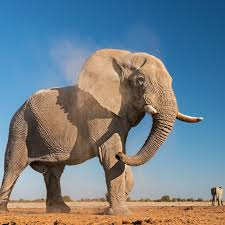
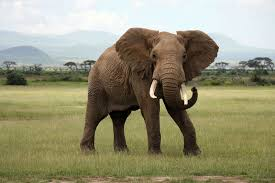
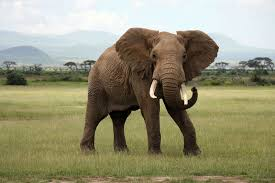
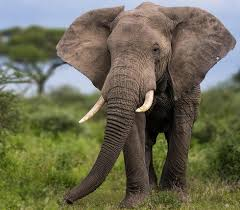
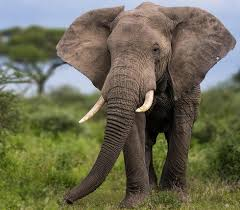
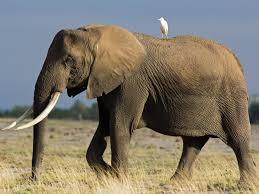
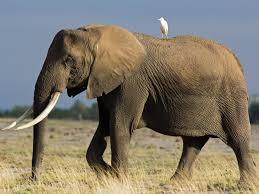
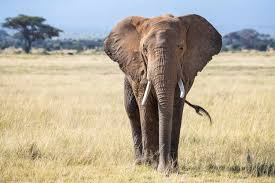
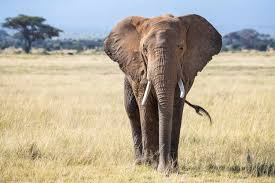
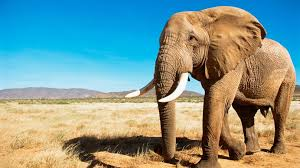
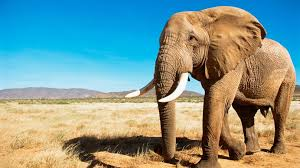
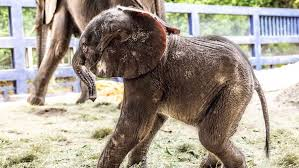
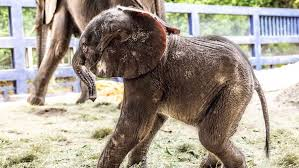
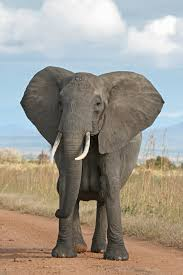
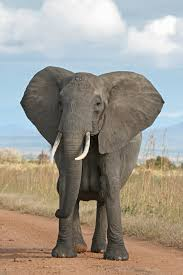
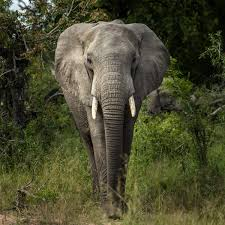
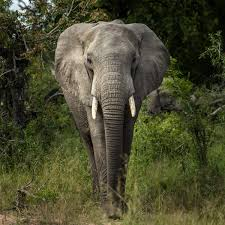
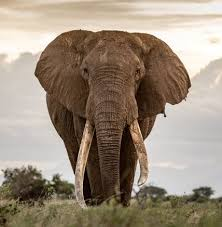
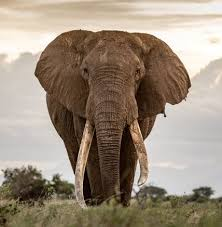
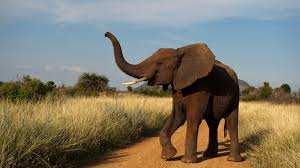
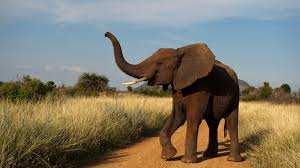
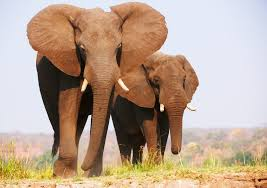
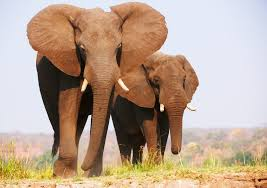
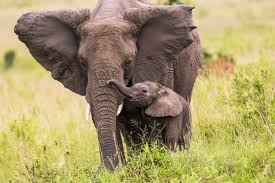
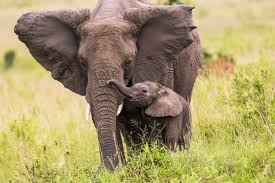
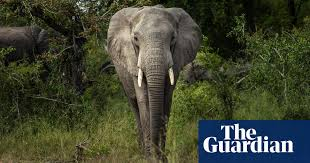
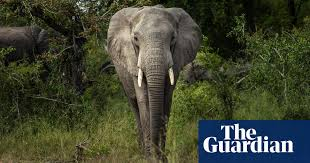
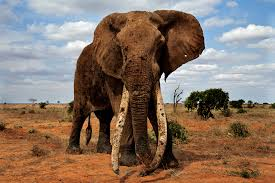
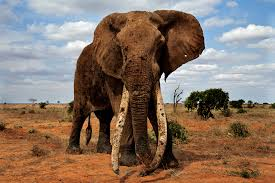
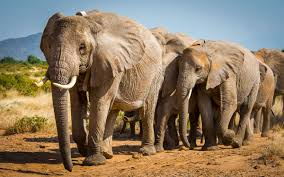
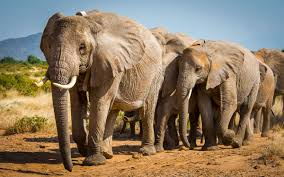
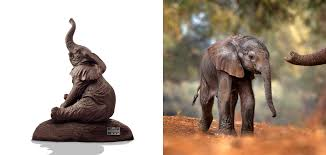
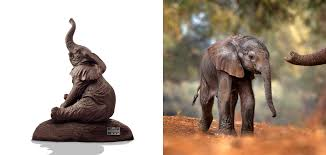
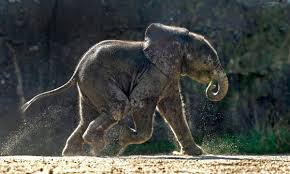
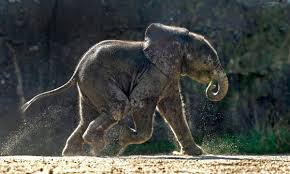
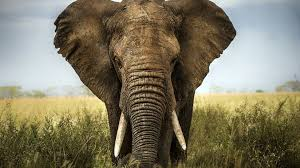
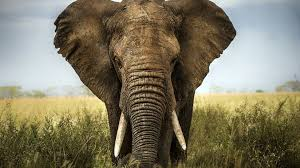
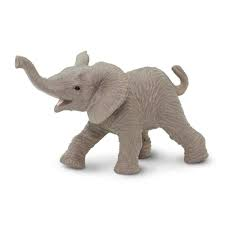
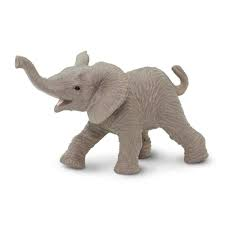
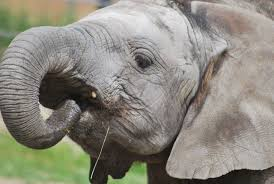
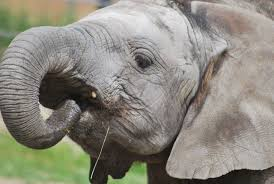
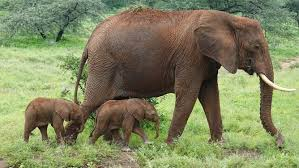
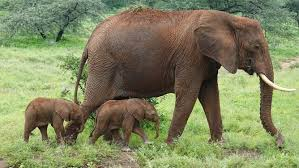
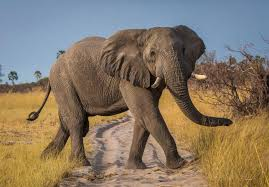
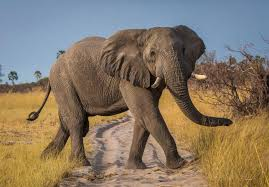
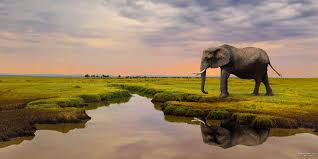
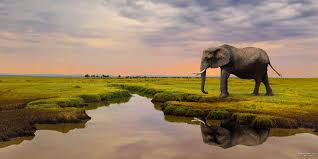
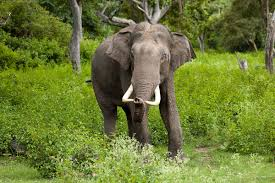
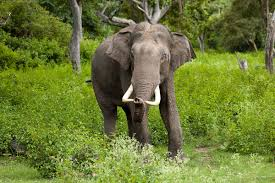
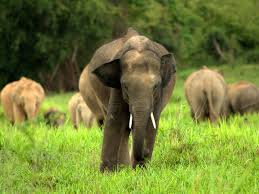
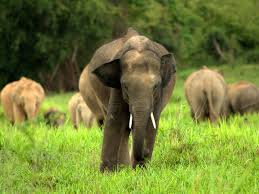
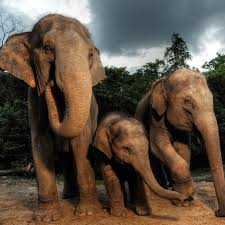
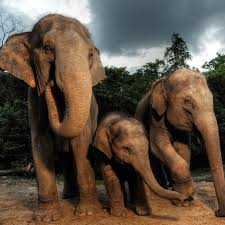
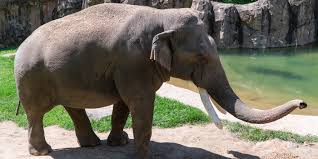
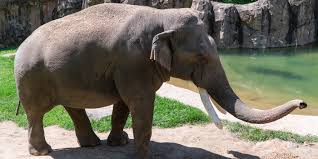
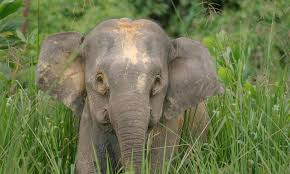
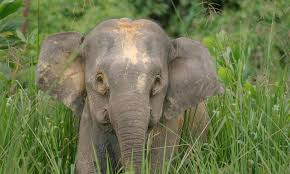
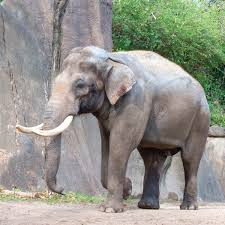
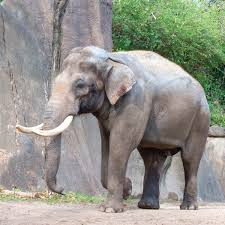
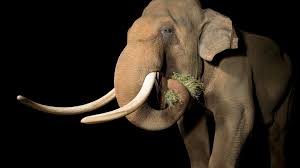
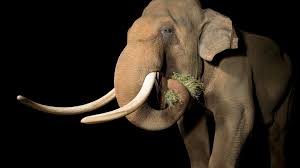
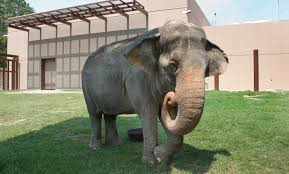
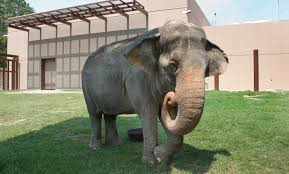
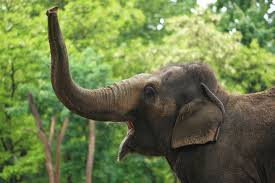
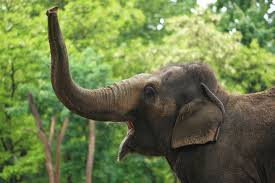
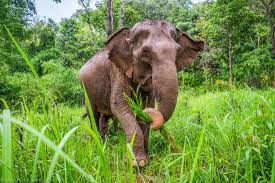
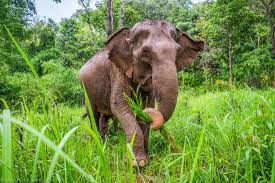
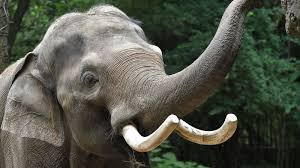
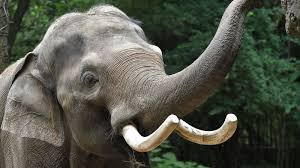
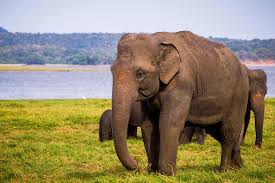
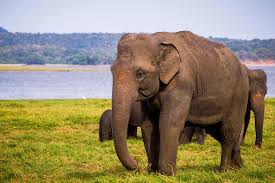
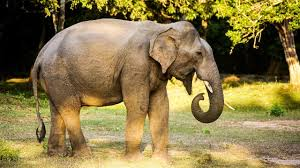
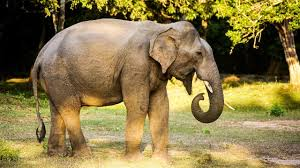
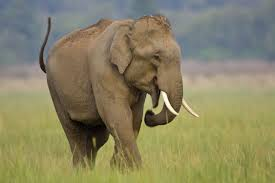
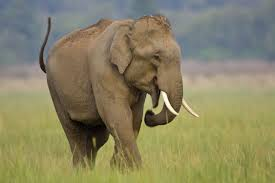
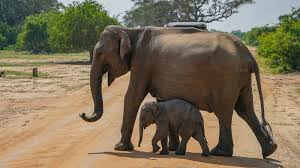
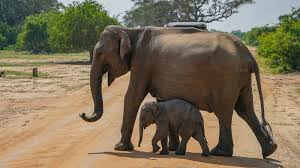
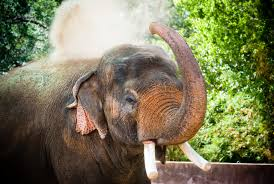
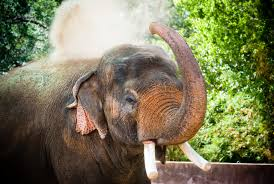
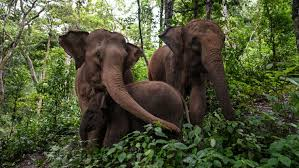
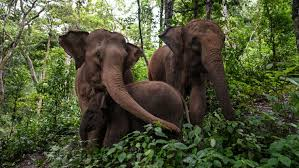
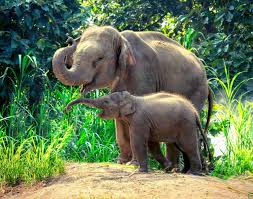
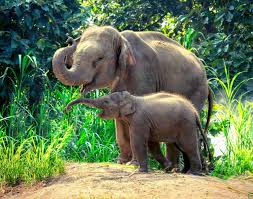
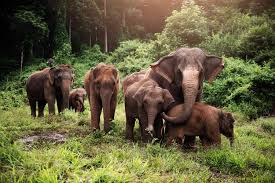
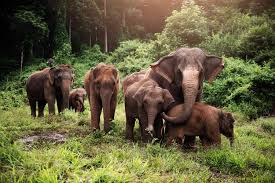
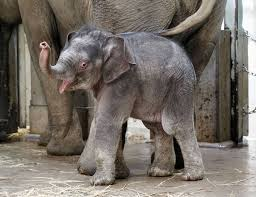
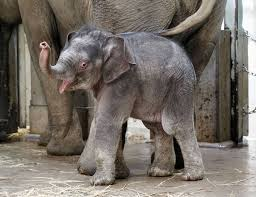
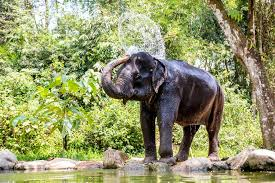
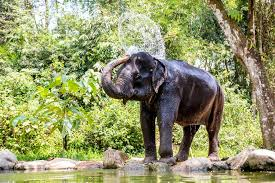
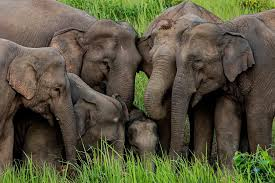
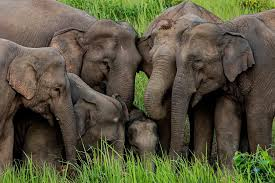
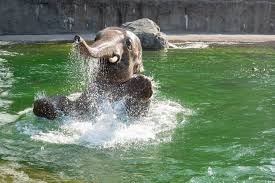
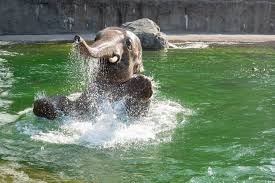
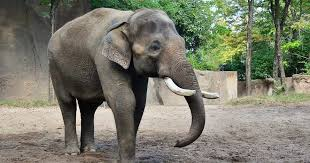
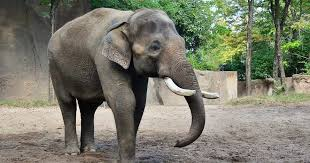
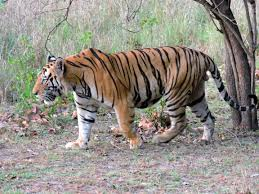
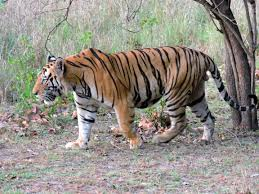
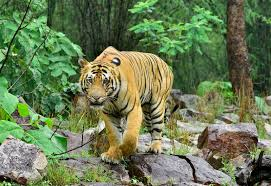
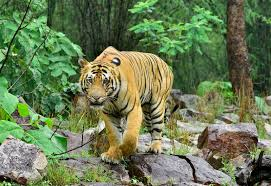
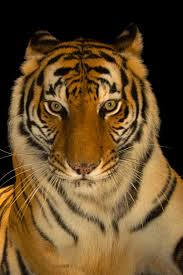
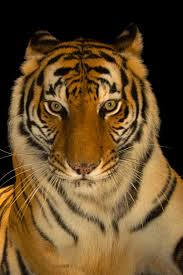
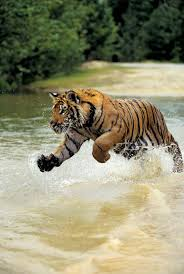
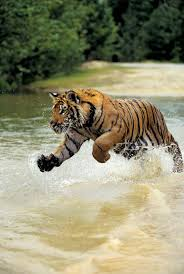
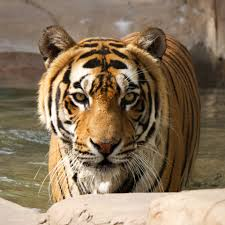
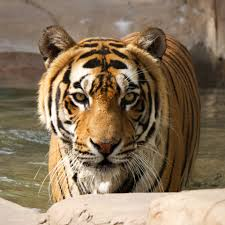
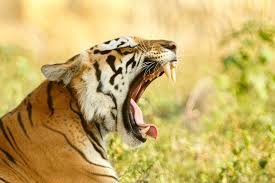
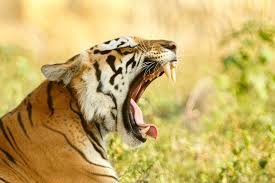
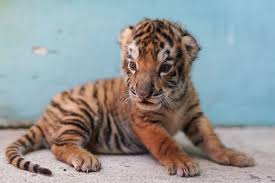
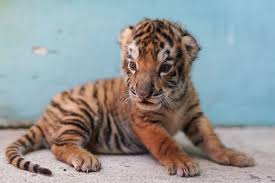
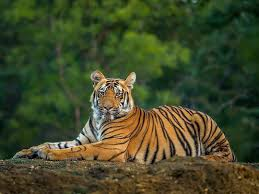
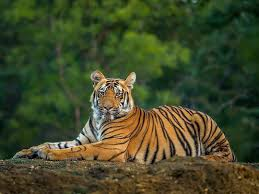
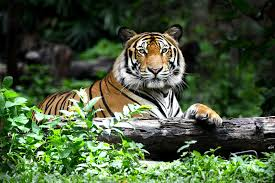
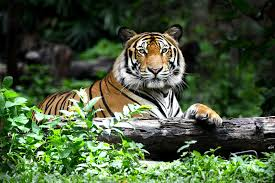
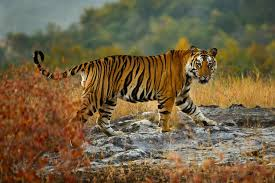
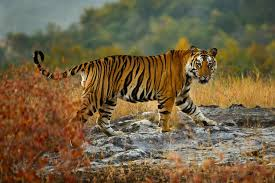
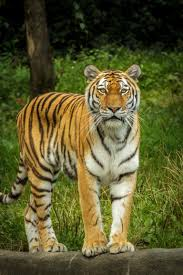
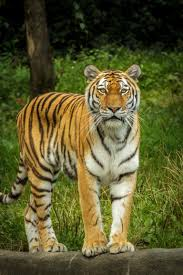
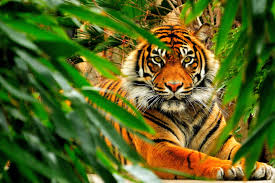
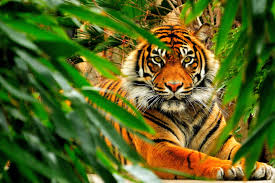
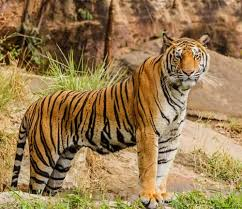
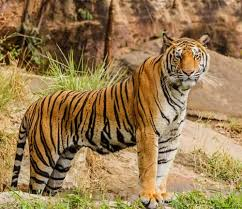
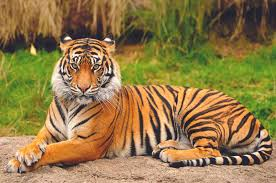
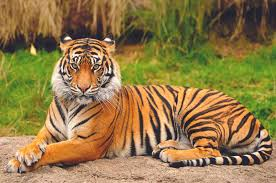
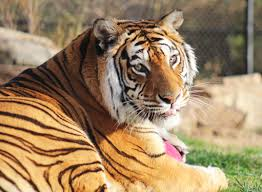
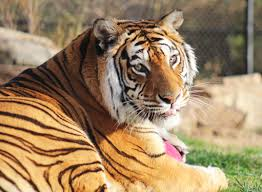
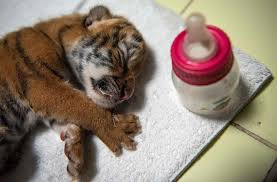
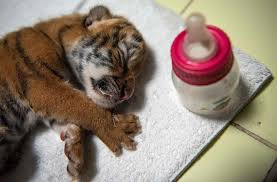
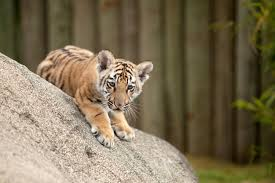
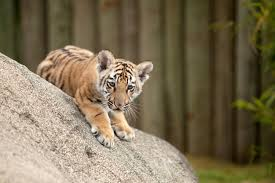
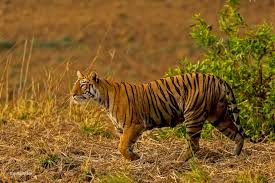
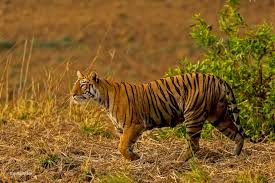
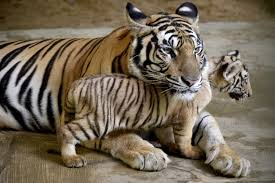
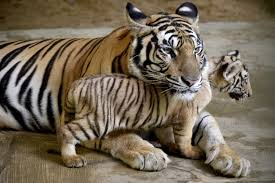
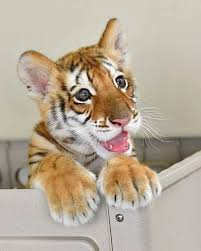
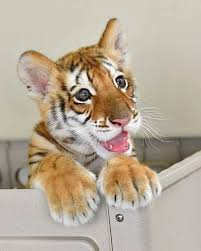
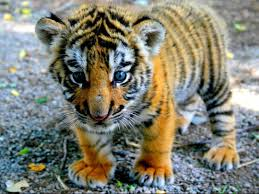
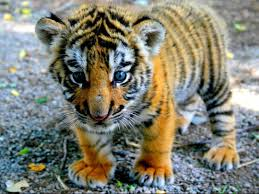
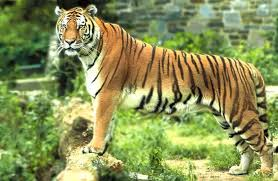
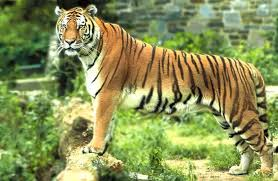
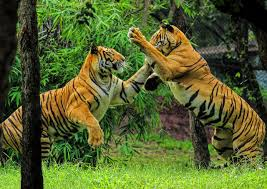
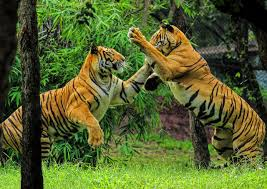
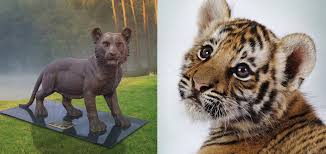
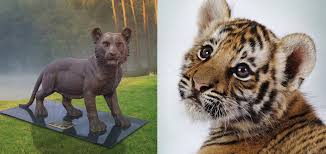
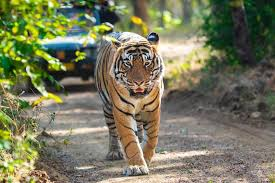
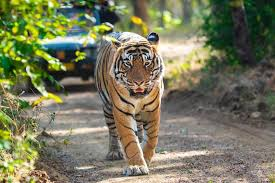
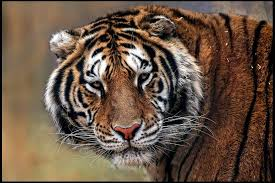
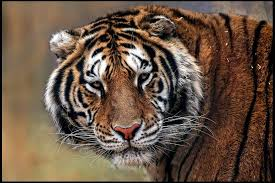
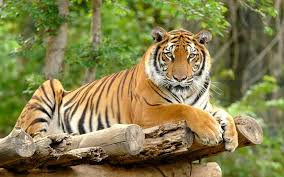
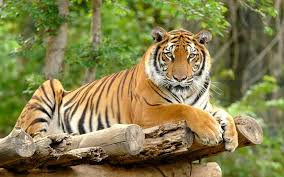
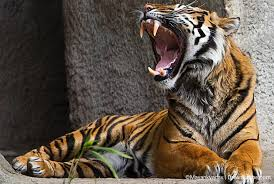
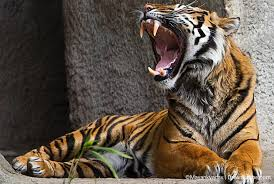
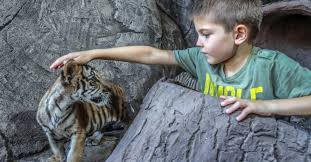
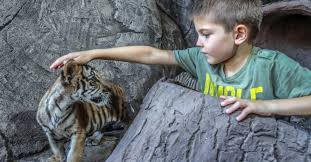
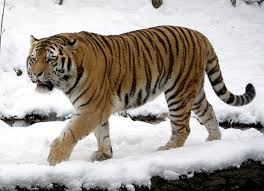
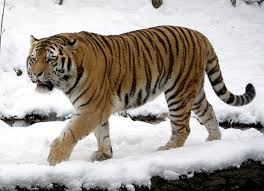
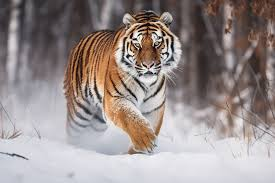
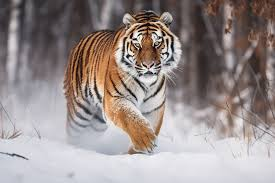
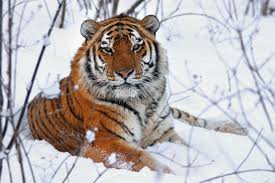
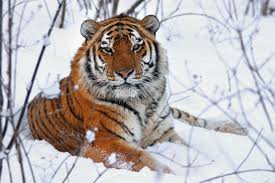
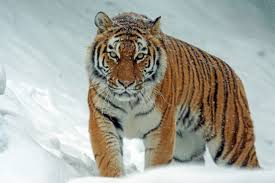
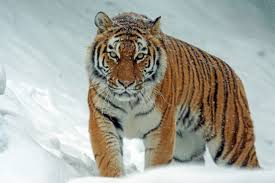
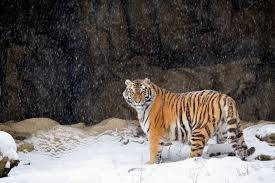
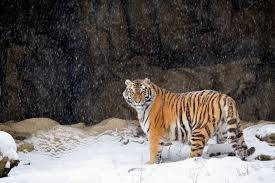
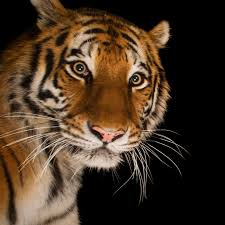
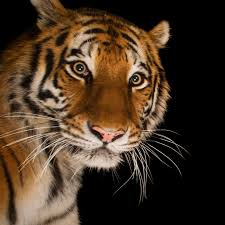
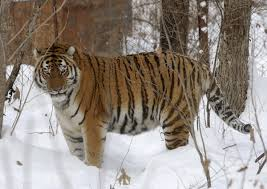
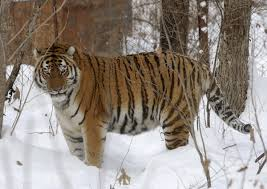
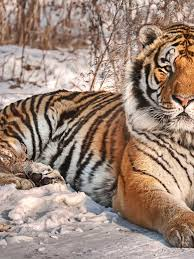
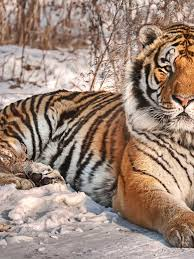
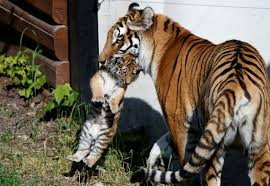
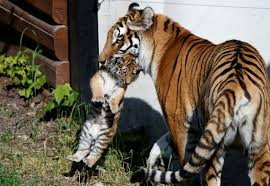
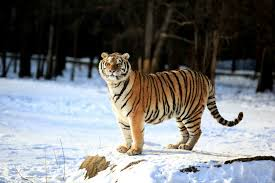
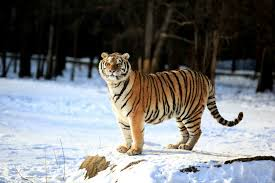
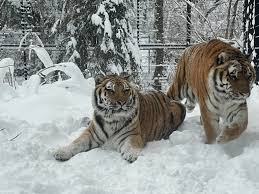
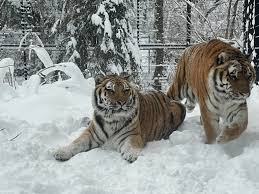
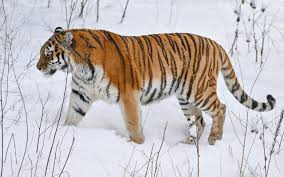
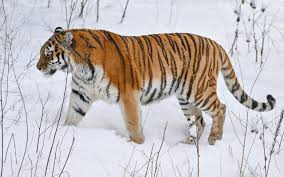
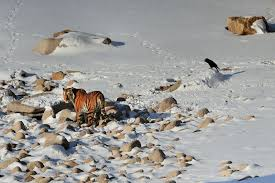
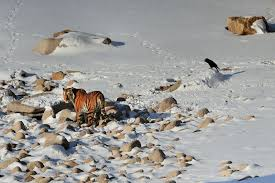
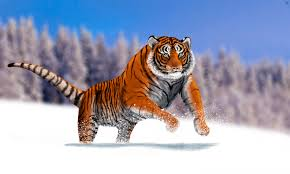
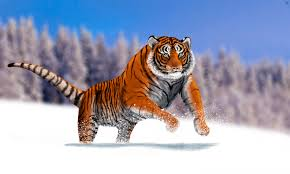
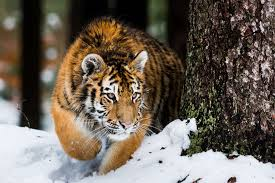
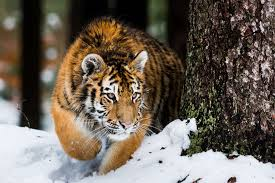
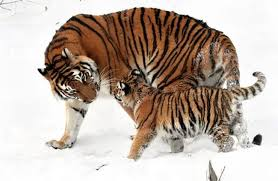
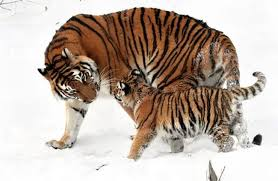
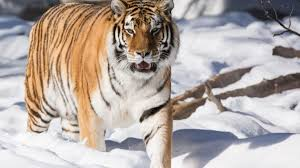
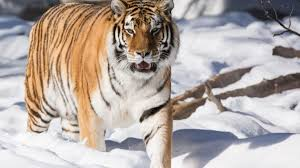
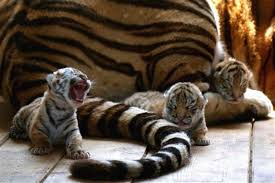
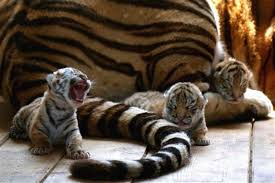
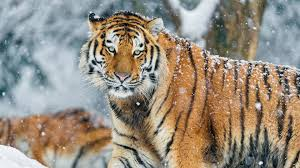
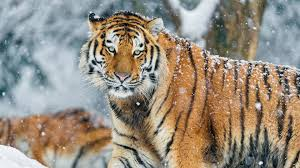
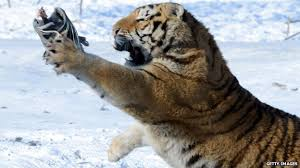
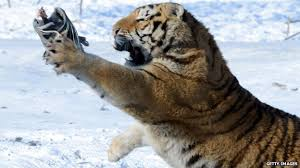
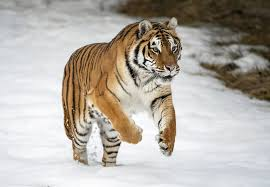
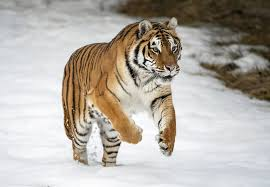
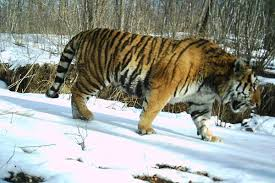
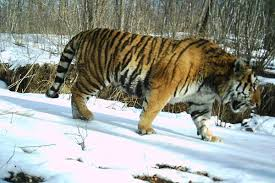
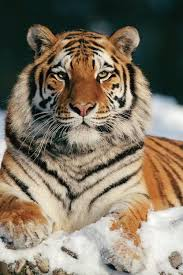
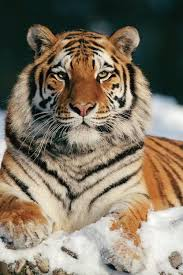
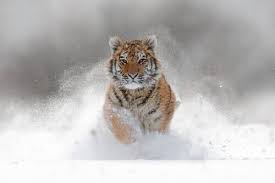
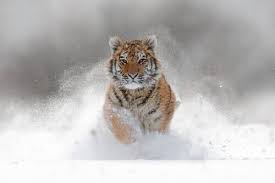
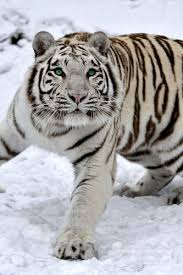
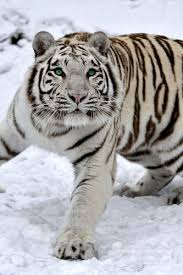
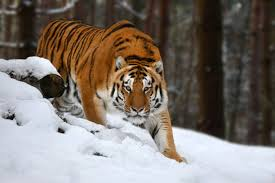
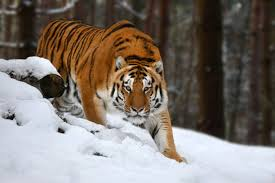
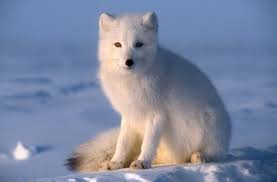
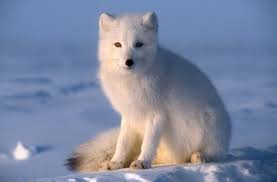
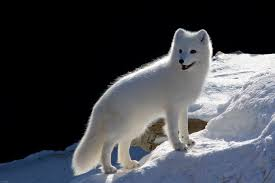
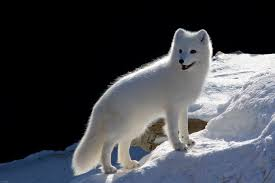
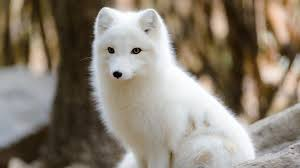
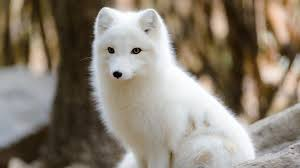
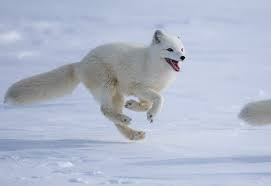
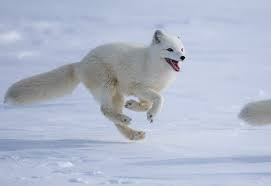
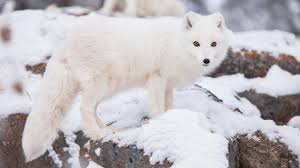
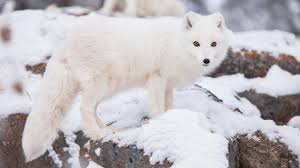
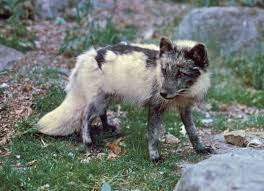
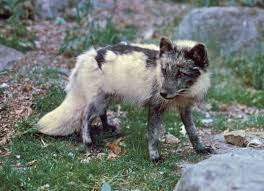
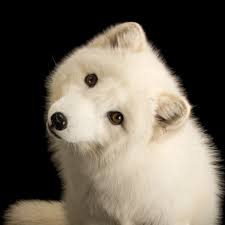
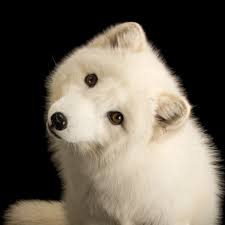
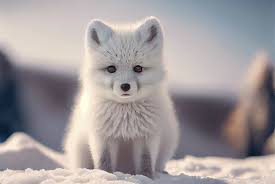
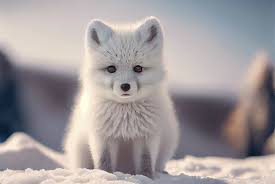
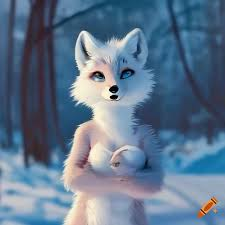
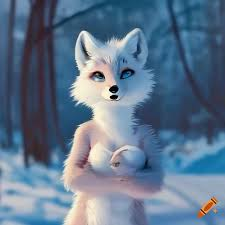
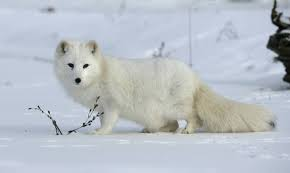
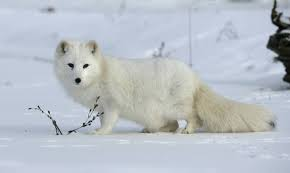
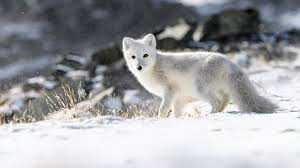
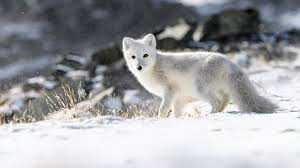
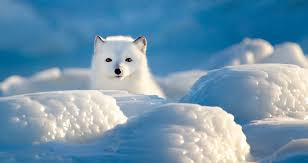
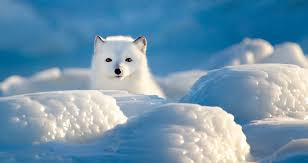
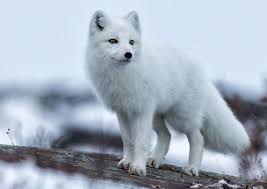
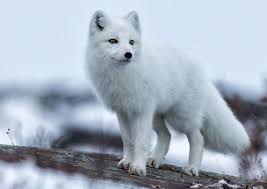
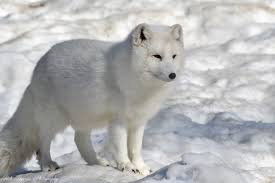
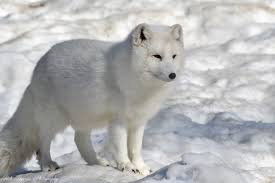
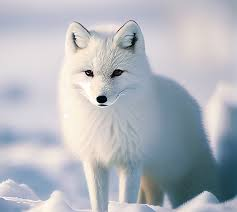
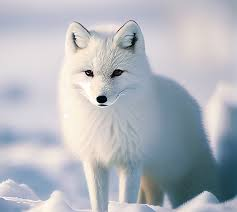
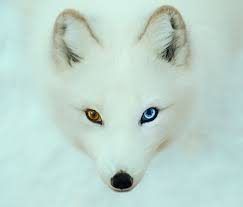
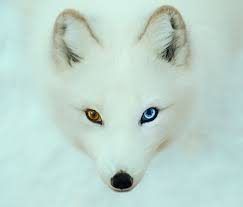
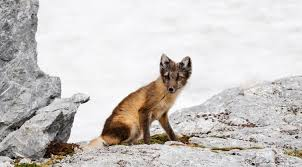
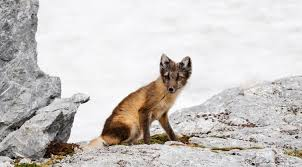
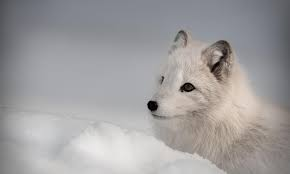
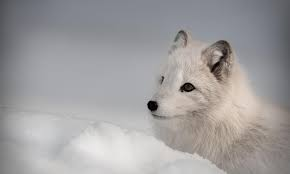
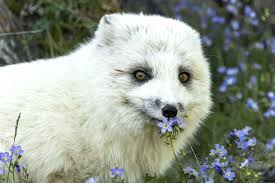
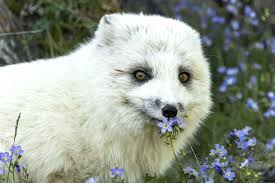
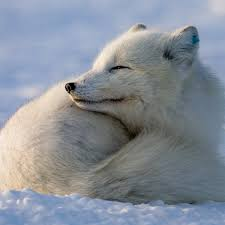
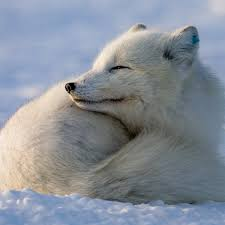
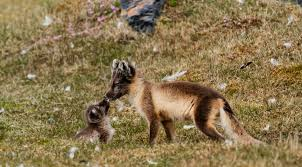
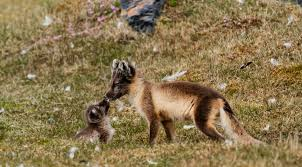
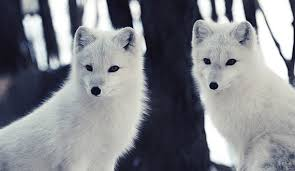
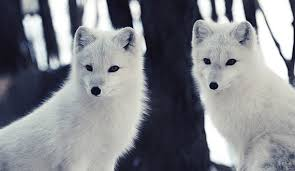
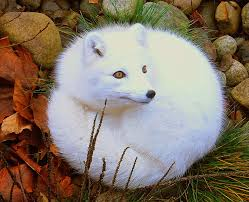
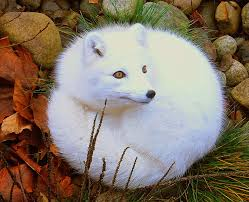
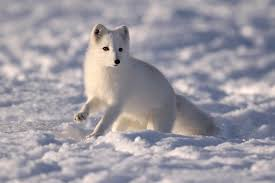
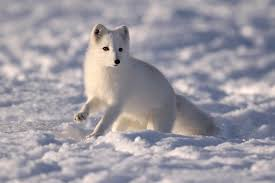
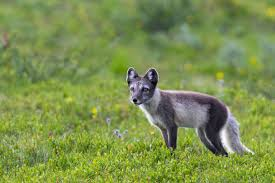
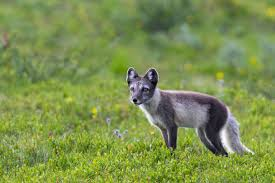
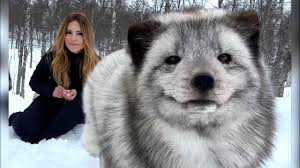
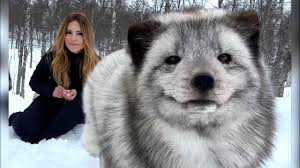
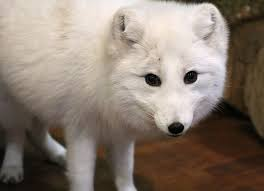
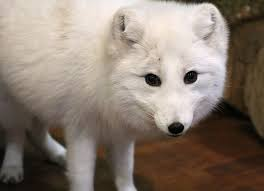
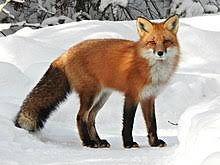
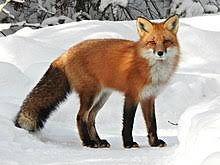
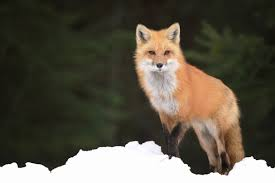
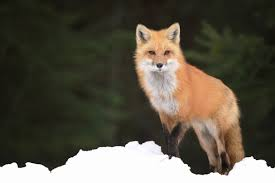
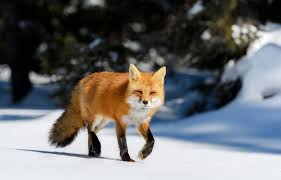
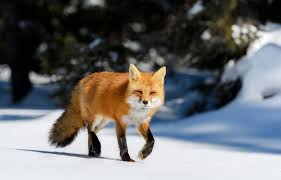
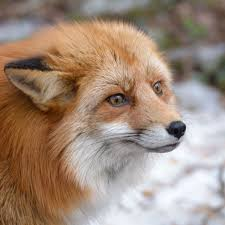
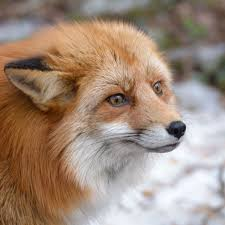
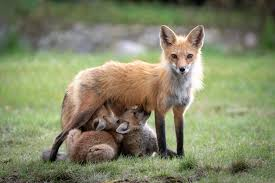
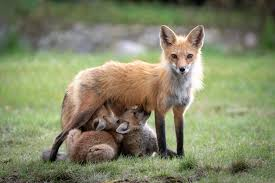
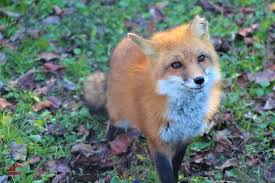
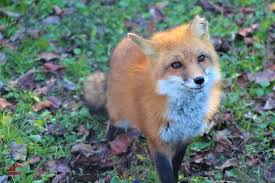
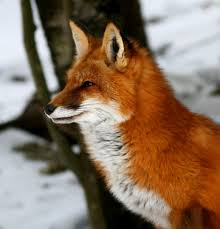
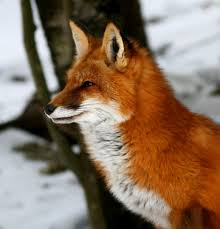
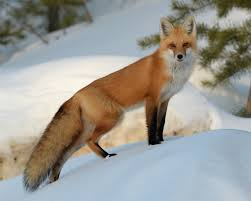
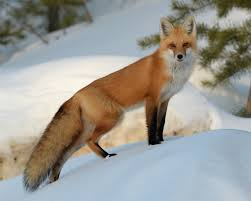
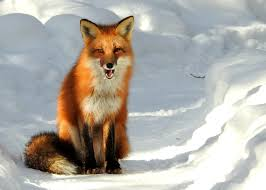
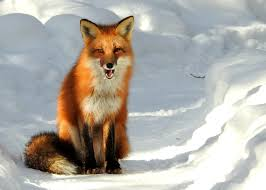
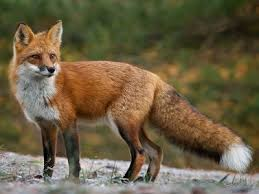
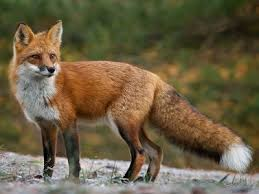
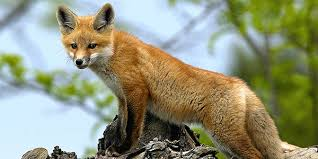
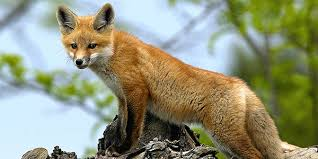
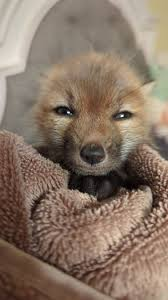
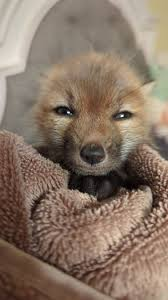
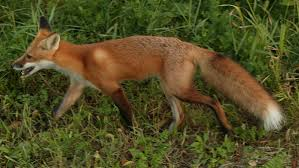
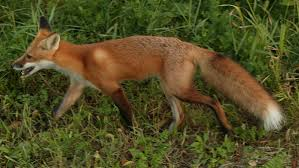
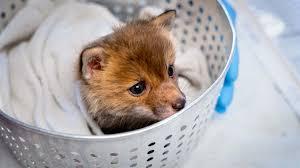
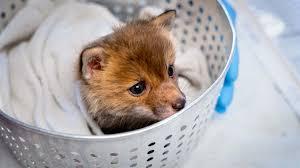
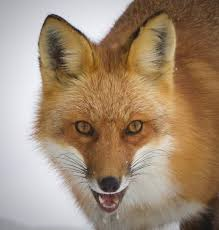
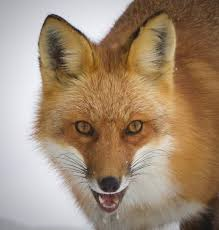
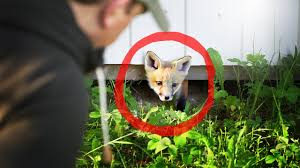
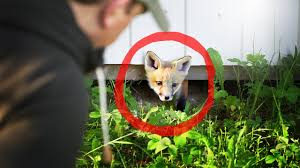
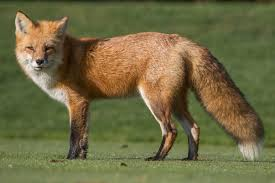
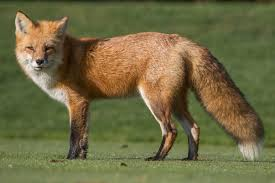
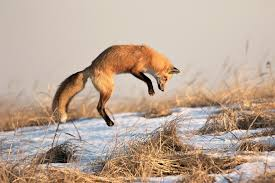
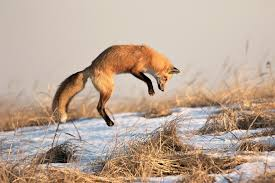
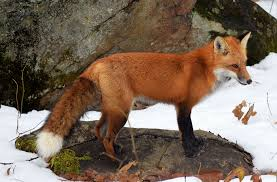
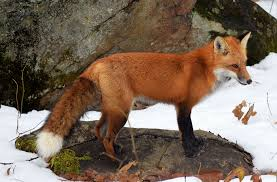
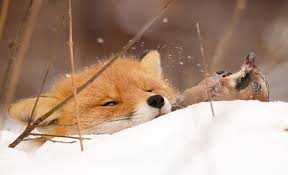
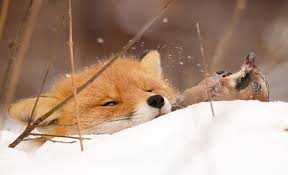
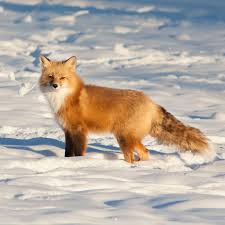
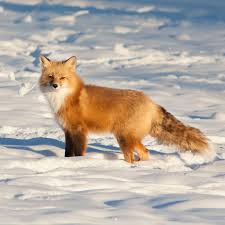
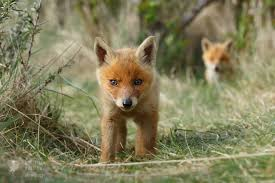
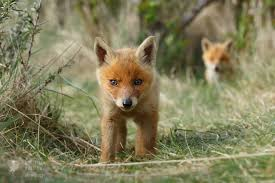
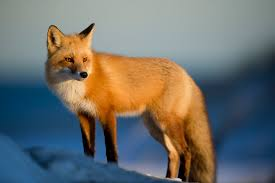
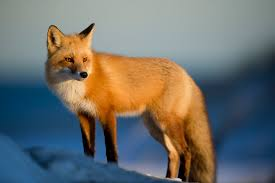
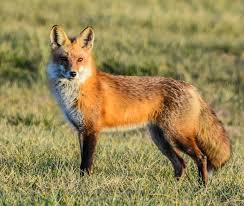
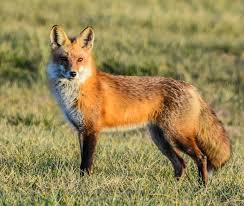
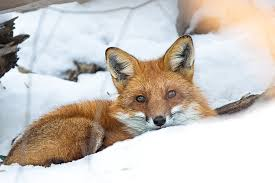
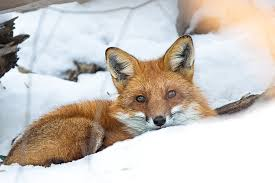
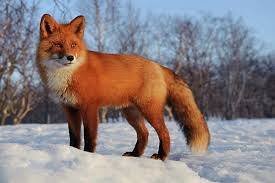
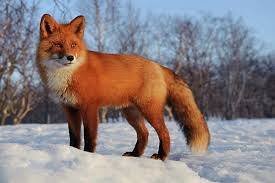
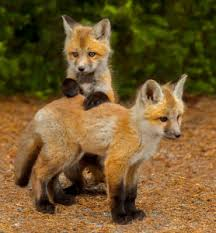
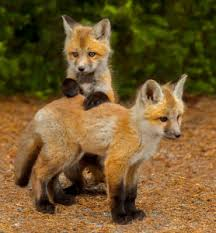

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

import hashlib
import io
import requests
from selenium import webdriver
from selenium.webdriver import ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from pathlib import Path
import time

# Specify the path to the ChromeDriver executable if not in PATH
# driver_path = "path/to/chromedriver"
# options = ChromeOptions()
# options.add_argument("--headless")  # Run Chrome in headless mode
# driver = webdriver.Chrome(executable_path=driver_path, options=options)

options = ChromeOptions()
options.add_argument("--headless")  # Run Chrome in headless mode
options.add_argument("--no-sandbox") # Bypass OS security model
driver = webdriver.Chrome(options=options)

def get_image_urls_google(soup):
    images = soup.find_all('img', class_='YQ4gaf')
    image_urls = []
    for image in images:
        # Ensure the image has only the class 'YQ4gaf'
        if len(image.get('class', [])) == 1:
            image_url = image.get('data-src') or image.get('src')
            if image_url:
                image_urls.append(image_url)
    return image_urls

def scroll_down_page():
    # Scroll down to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Adjust sleep time as necessary to allow images to load

def crawl_pages_google(start_url):
    driver.get(start_url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//img[@class="YQ4gaf"]')))
    all_image_urls = []
    previous_height = driver.execute_script('return document.body.scrollHeight')

    while True:
        scroll_down_page()
        time.sleep(2)  # Adjust sleep time as necessary
        new_height = driver.execute_script('return document.body.scrollHeight')

        if new_height == previous_height:
            break

        previous_height = new_height

    content = driver.page_source
    soup = BeautifulSoup(content, "html.parser")
    all_image_urls = get_image_urls_google(soup)

    return all_image_urls

def download_images(image_urls, category_name, source):
    if image_urls:
        data_dir_path = Path(f"data/{category_name}")
        data_dir_path.mkdir(parents=True, exist_ok=True)

        for idx, image_url in enumerate(image_urls, start=1):
            try:
                image_content = requests.get(image_url).content
                image_hash = hashlib.sha1(image_content).hexdigest()[:10]  # Get first 10 characters of hash
                file_path = data_dir_path / f"{category_name}_{idx}_{image_hash}.png"

                # Check if file exists, increment index until a unique name is found
                while file_path.exists():
                    idx += 1
                    file_path = data_dir_path / f"{category_name}_{idx}_{image_hash}.png"

                with open(file_path, 'wb') as f:
                    f.write(image_content)

                print(f"Downloaded {file_path}")
            except Exception as e:
                print(f"Failed to download {image_url}: {e}")
    else:
        print(f"No images found for {category_name}")

def scrape_and_download_google(categories):
    for category_name, start_url in categories.items():
        print(f"Scraping images from Google for {category_name}...")
        all_image_urls = crawl_pages_google(start_url)
        download_images(all_image_urls, category_name, source="google")

if __name__ == "__main__":
    google_categories = {
        "african_elephant": "https://www.google.com/search?q=african+elephant&tbm=isch&tbs=itp:photo",
        "asian_elephant": "https://www.google.com/search?q=asian+elephant&tbm=isch&tbs=itp:photo",
        "bengal_tiger": "https://www.google.com/search?q=bengal+tiger&tbm=isch&tbs=itp:photo",
        "siberian_tiger": "https://www.google.com/search?q=siberian+tiger&tbm=isch&tbs=itp:photo",
        "arctic_fox": "https://www.google.com/search?q=arctic+fox&tbm=isch&tbs=itp:photo",
        "red_fox": "https://www.google.com/search?q=red+fox&tbm=isch&tbs=itp:photo"
    }

    scrape_and_download_google(google_categories)

    driver.quit()


**Split the datasets into training, testing and validation**

In [7]:
import shutil
from sklearn.model_selection import train_test_split
import os

# Define paths
base_dir = r"/content/data"
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# already have class folders
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Create subdirectories for each class in train, val, and test directories
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Split the data
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    # Look for images with common extensions (case-insensitive)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Found {len(images)} images in {class_name} class.")

    if len(images) > 0:  # Check if images were found
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}, Test images: {len(test_images)}")

        for img in train_images:
            shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))
        for img in val_images:
            shutil.copy(img, os.path.join(val_dir, class_name, os.path.basename(img)))
        for img in test_images:
            shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))
    else:
        print(f"No images found in {class_name} class. Skipping split.")

print("Data has been organized into train, val, and test directories.")

Found 0 images in train class.
No images found in train class. Skipping split.
Found 598 images in african_elephant class.
Train images: 418, Validation images: 90, Test images: 90
Found 588 images in red_fox class.
Train images: 411, Validation images: 88, Test images: 89
Found 0 images in val class.
No images found in val class. Skipping split.
Found 0 images in test class.
No images found in test class. Skipping split.
Found 558 images in bengal_tiger class.
Train images: 390, Validation images: 84, Test images: 84
Found 560 images in arctic_fox class.
Train images: 392, Validation images: 84, Test images: 84
Found 671 images in asian_elephant class.
Train images: 469, Validation images: 101, Test images: 101
Found 566 images in siberian_tiger class.
Train images: 396, Validation images: 85, Test images: 85
Data has been organized into train, val, and test directories.


In [8]:
# Split the data
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))] # handle upper and lower case extensions

    if images: # Check if any images were found
        print(f"Found {len(images)} images in {class_name} class.")

        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}, Test images: {len(test_images)}")

        for img in train_images:
            shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))
        for img in val_images:
            shutil.copy(img, os.path.join(val_dir, class_name, os.path.basename(img)))
        for img in test_images:
            shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))
    else:
        print(f"No images found in {class_name} class. Skipping split.")

print("Data has been organized into train, val, and test directories.")

No images found in train class. Skipping split.
Found 598 images in african_elephant class.
Train images: 418, Validation images: 90, Test images: 90
Found 588 images in red_fox class.
Train images: 411, Validation images: 88, Test images: 89
No images found in val class. Skipping split.
No images found in test class. Skipping split.
Found 558 images in bengal_tiger class.
Train images: 390, Validation images: 84, Test images: 84
Found 560 images in arctic_fox class.
Train images: 392, Validation images: 84, Test images: 84
Found 671 images in asian_elephant class.
Train images: 469, Validation images: 101, Test images: 101
Found 566 images in siberian_tiger class.
Train images: 396, Validation images: 85, Test images: 85
Data has been organized into train, val, and test directories.


**Load Data**

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define constants
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'
input_shape = (128, 128)
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories and apply data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2476 images belonging to 9 classes.
Found 532 images belonging to 9 classes.


**Define model architecture**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

# Define number of classes
num_classes = len(os.listdir(train_dir))  # Dynamically determine number of classesczwwwwwwwwwwwwwwwwwddwwdd

# Load pre-trained models without top layers
base_models = [
    ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
]

# Model Building
# Build custom models on top of each base model
models = []
for base_model in base_models:
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))
    models.append(model)

# Model compilation
# Compile the models
for model in models:
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summaries
for i, model in enumerate(models):
    print(f"Model {i+1} Summary:")
    model.summary()
    print()

# Setting up Data Generators
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

batch_size = 32
target_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define callbacks to prevent overfitting etc
checkpoint_path = 'model_checkpoints/model_{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Training loop
for model in models:
    print(f"Training Model {models.index(model) + 1}...")
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=30,  # Adjusted to 30 epochs
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping]
    )

    end_time = time.time()
    training_duration = end_time - start_time
    print(f"Training duration for Model {models.index(model) + 1}: {training_duration:.2f} seconds")

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")



    print()

# Print final conclusions or comparisons based on metrics and training times
print("Training and evaluation complete.")

9406464/9406464 [==============================] - 0s 0us/step
Model 1 Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 23606153 (90.05 MB)
Trainable params: 23553033 (89.85 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________

Model 2 Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 59s 260ms/step - loss: 1.6698 - accuracy: 0.4798 - val_loss: 272.2447 - val_accuracy: 0.1598
Epoch 2/30
78/78 [==============================] - ETA: 0s - loss: 1.0117 - accuracy: 0.6058
Epoch 2: val_loss improved from 272.24466 to 1.94445, saving model to model_checkpoints/model_02-1.94.h5
78/78 [==============================] - 17s 216ms/step - loss: 1.0117 - accuracy: 0.6058 - val_loss: 1.9444 - val_accuracy: 0.1579
Epoch 3/30
78/78 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.6454
Epoch 3: val_loss did not improve from 1.94445
78/78 [==============================] - 15s 197ms/step - loss: 0.8722 - accuracy: 0.6454 - val_loss: 2.0207 - val_accuracy: 0.1579
Epoch 4/30
78/78 [==============================] - ETA: 0s - loss: 0.7730 - accuracy: 0.6862
Epoch 4: val_loss did not improve from 1.94445
78/78 [==============================] - 15s 195ms/step - loss: 0.7730 - accuracy: 0.6862 - val_loss: 2.2081 - val_accura

**Visualize the performance of the every models**

**Graphs for model loss and accuracy.**

Found 2476 images belonging to 9 classes.
Found 532 images belonging to 9 classes.
Found 533 images belonging to 9 classes.
Training model 1
Epoch 1/10
78/78 [==============================] - 5s 41ms/step - loss: 3.0118 - accuracy: 0.3312 - val_loss: 1.3860 - val_accuracy: 0.4436
Epoch 2/10
78/78 [==============================] - 4s 54ms/step - loss: 1.0761 - accuracy: 0.6224 - val_loss: 1.3057 - val_accuracy: 0.4718
Epoch 3/10
78/78 [==============================] - 3s 38ms/step - loss: 0.6587 - accuracy: 0.8098 - val_loss: 1.3197 - val_accuracy: 0.4925
Epoch 4/10
78/78 [==============================] - 3s 39ms/step - loss: 0.3747 - accuracy: 0.9091 - val_loss: 1.6450 - val_accuracy: 0.4624
Epoch 5/10
78/78 [==============================] - 3s 40ms/step - loss: 0.2427 - accuracy: 0.9507 - val_loss: 1.5124 - val_accuracy: 0.4699
Epoch 6/10
78/78 [==============================] - 4s 51ms/step - loss: 0.1816 - accuracy: 0.9673 - val_loss: 1.6387 - val_accuracy: 0.4568
Epoch 7/10
78

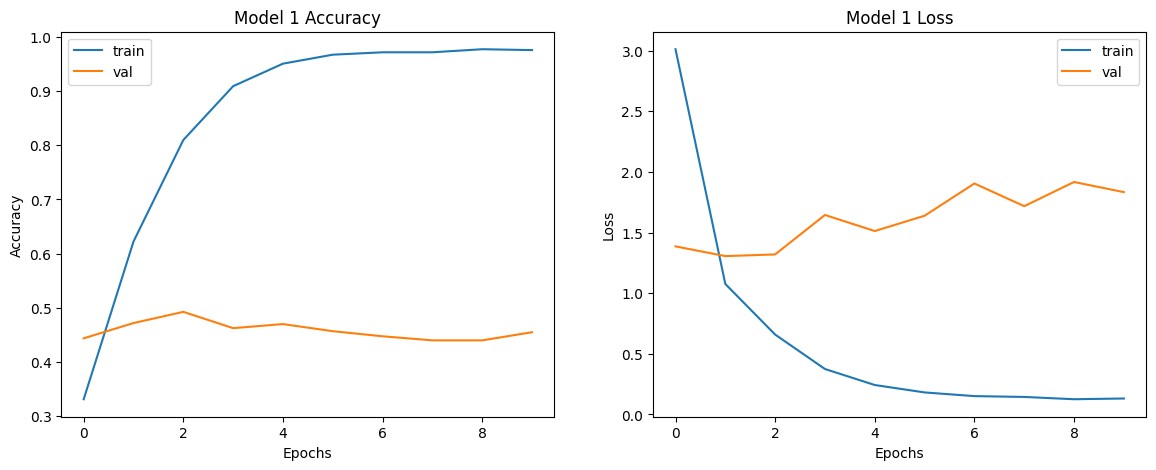

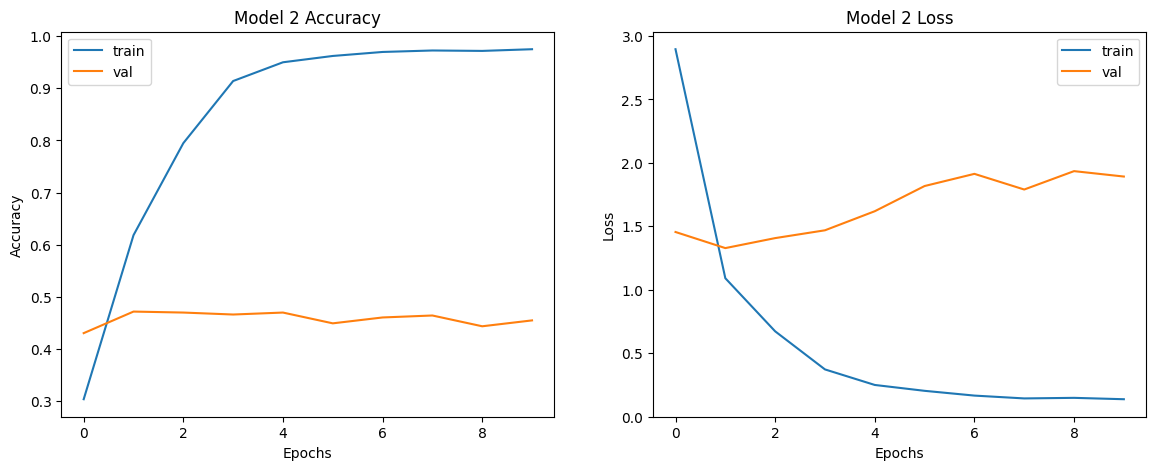

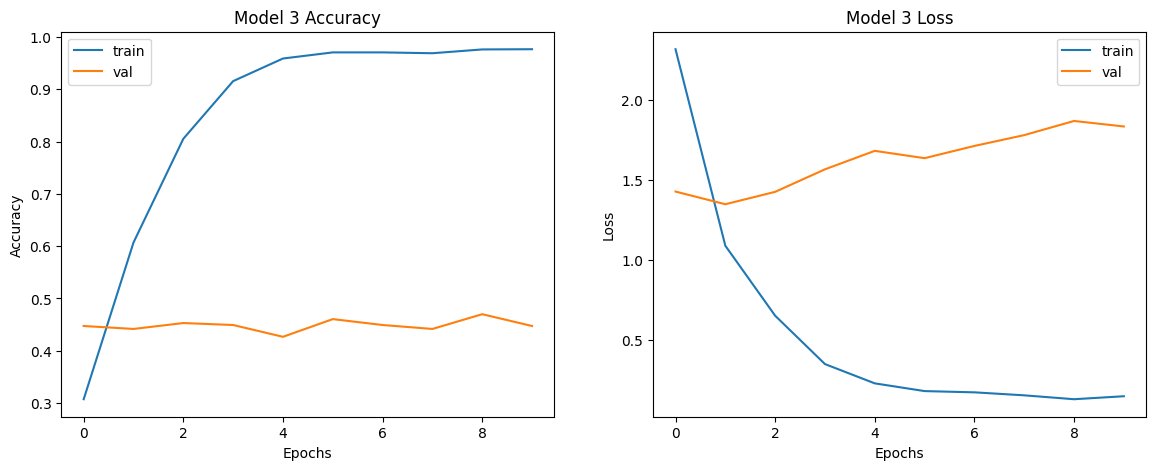

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import time

# Define image size and batch size
image_size = (150, 150)
batch_size = 32

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define a simple CNN model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # Add convolutional layer
        tf.keras.layers.MaxPooling2D((2, 2)), # Add pooling layer
        tf.keras.layers.Flatten(), # Flatten the output for the Dense layer
        tf.keras.layers.Dense(9, activation='softmax')  # Change to 9 classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate multiple models
models = []
histories = []
for i in range(3):  # Example with 3 models
    print(f"Training model {i+1}")
    model = create_model()
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )
    training_time = time.time() - start_time
    models.append((model, training_time))
    histories.append(history)

# Evaluate and visualize the models
def plot_metrics(histories):
    for i, history in enumerate(histories):
        plt.figure(figsize=(14, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='val')
        plt.title(f'Model {i+1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.title(f'Model {i+1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

plot_metrics(histories)

# Confusion Matrix and Classification Report
def evaluate_model(model, test_generator):
    # Predict probabilities for test set
    Y_pred = model.predict(test_generator)

    # Get the predicted classes
    y_pred = np.argmax(Y_pred, axis=1)

    # Get the true classes
    y_true = test

**Display the evaluation using confusion matrix**

Evaluating model 1
17/17 [==============================] - 1s 37ms/step


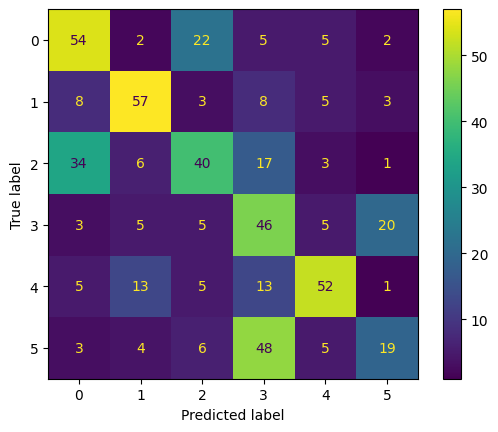

                  precision    recall  f1-score   support

african_elephant       0.50      0.60      0.55        90
      arctic_fox       0.66      0.68      0.67        84
  asian_elephant       0.49      0.40      0.44       101
    bengal_tiger       0.34      0.55      0.42        84
         red_fox       0.69      0.58      0.63        89
  siberian_tiger       0.41      0.22      0.29        85

        accuracy                           0.50       533
       macro avg       0.52      0.51      0.50       533
    weighted avg       0.52      0.50      0.50       533

Overall Accuracy: 0.5028
Evaluating model 2
17/17 [==============================] - 1s 32ms/step


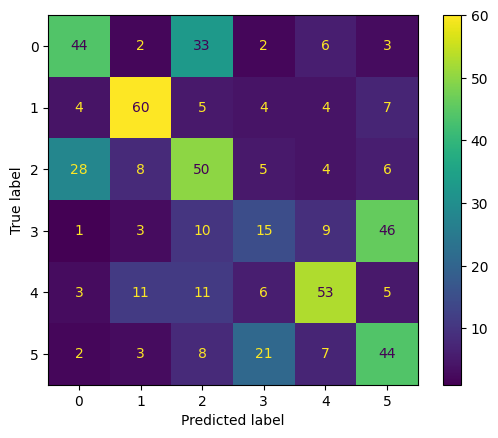

                  precision    recall  f1-score   support

african_elephant       0.54      0.49      0.51        90
      arctic_fox       0.69      0.71      0.70        84
  asian_elephant       0.43      0.50      0.46       101
    bengal_tiger       0.28      0.18      0.22        84
         red_fox       0.64      0.60      0.62        89
  siberian_tiger       0.40      0.52      0.45        85

        accuracy                           0.50       533
       macro avg       0.50      0.50      0.49       533
    weighted avg       0.49      0.50      0.49       533

Overall Accuracy: 0.4991
Evaluating model 3
17/17 [==============================] - 1s 31ms/step


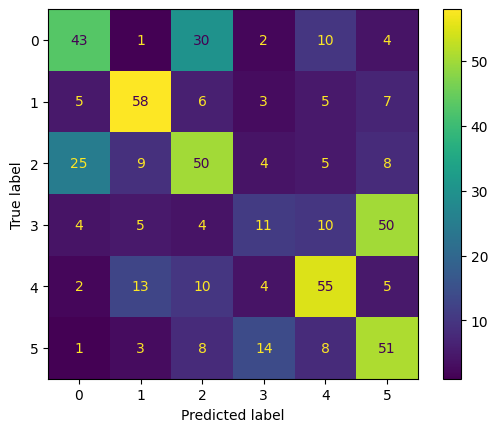

                  precision    recall  f1-score   support

african_elephant       0.54      0.48      0.51        90
      arctic_fox       0.65      0.69      0.67        84
  asian_elephant       0.46      0.50      0.48       101
    bengal_tiger       0.29      0.13      0.18        84
         red_fox       0.59      0.62      0.60        89
  siberian_tiger       0.41      0.60      0.49        85

        accuracy                           0.50       533
       macro avg       0.49      0.50      0.49       533
    weighted avg       0.49      0.50      0.49       533

Overall Accuracy: 0.5028
Model 1 Training Time: 39.39 seconds
Model 1 Confusion Matrix:
[[54  2 22  5  5  2]
 [ 8 57  3  8  5  3]
 [34  6 40 17  3  1]
 [ 3  5  5 46  5 20]
 [ 5 13  5 13 52  1]
 [ 3  4  6 48  5 19]]
Model 1 Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.50      0.60      0.55        90
      arctic_fox       0.66      0.68      0.67       

In [24]:
# Confusion Matrix and Classification Report
def evaluate_model(model, test_generator):
    # Predict probabilities for test set
    Y_pred = model.predict(test_generator)

    # Get the predicted classes
    y_pred = np.argmax(Y_pred, axis=1)

    # Get the true classes
    y_true = test_generator.classes  # Use test_generator.classes for true labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    # Get number of classes from the confusion matrix
    num_classes = cm.shape[0]
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(range(num_classes))).plot() # Use number of classes as labels
    plt.show()  # Display the plot

    # Classification Report - Get the actual predicted class names
    predicted_class_indices = np.unique(y_pred)
    predicted_class_names = [list(test_generator.class_indices.keys())[i] for i in predicted_class_indices]

    cr = classification_report(y_true, y_pred, target_names=predicted_class_names) # Use predicted class names
    print(cr)

    # Calculate overall accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Overall Accuracy: {accuracy:.4f}")

    return cm, cr, accuracy

evaluations = []
for i, (model, training_time) in enumerate(models):
    print(f"Evaluating model {i+1}")
    cm, cr, accuracy = evaluate_model(model, test_generator)
    evaluations.append((cm, cr, accuracy, training_time))

# Final conclusions
for i, (cm, cr, accuracy, training_time) in enumerate(evaluations):
    print(f"Model {i+1} Training Time: {training_time:.2f} seconds")
    print(f"Model {i+1} Confusion Matrix:\n{cm}")
    print(f"Model {i+1} Classification Report:\n{cr}")
    print(f"Model {i+1} Overall Accuracy: {accuracy:.4f}")

**Final Conclusion**

Training Time: Model 3 has the shortest training time, followed closely by Model 1.
Overall Accuracy: Models 1 and 3 have the highest overall accuracy (0.5028).
Class-Specific Performance: All models show better performance on arctic_fox and red_fox, with lower performance on bengal_tiger.

**Best Model Selection**

Given that Models 1 and 3 have the same overall accuracy and Model 3 has a slightly shorter training time, Model 3 can be considered the best-suited model for this classification task based on the provided metrics.